# Performance Analysis
In this Python notebook the algorithms will be assessed on their performance, more specifically the execution time of the algorithms will be analyzed.

In [17]:
# Libraries used in this python notebook
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from tqdm import tqdm
import time

In [ ]:
# Set the plot resolution
plt.rcParams['figure.dpi'] = 600

In [18]:
# The seed for the probabilistic functions
SEED = sum([ord(c) for c in "Social Networks Lab"])

In [19]:
# These are the algorithms, which we are assessing
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            # random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

In [20]:
# Determine the maximum number of Possession xG values per team and match
xg_df = pd.read_pickle('possession_xGs.pkl')
xg_counts = xg_df.groupby('match_id').apply(lambda df: df.groupby('team_id')['team_id'].count()).sort_values()
max_n = xg_counts.max()
print(f'Maximum number of Possession xG per team and match is {max_n}')

Maximum number of Possession xG per team and match is 43


As a rule of thumb to get a representative value for the execution time we repeat the algorithm with the same input such that the average aggregate running time is 1 second.

In [21]:
# For each unique number of Possession xG values per team and match, run the algorithms
REPEAT = 100
SIMULATION_RUNS = 10000
xg_counts = xg_counts.to_frame()
xg_counts.columns = ['xg_count']
xg_counts = xg_counts.reset_index()
# Iterate through the unique number of Possession xGs per team and match
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    # Choose a team and match with 'count' Possession xGs
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample(1, random_state=SEED)['match_id'].iat[0] # chosen match
    team_id = i_counts[i_counts['match_id'] == match_id].sample(1, random_state=SEED)['team_id'].iat[0] # chosen team from that match
    # Get the Possession xG list of the chosen team and match
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    execution_times_det = []
    execution_times_sim = []
    for _ in range(REPEAT):
        # Get average execution time for the deterministic algorithms
        start = time.time() 
        dp(p_is)
        fft(p_is)
        stop = time.time()
        execution_times_det.append((stop - start)/2)
        # Get execution time for the simulation algorithm
        start = time.time() 
        simulation(p_is, SIMULATION_RUNS)
        stop = time.time()
        execution_times_sim.append(stop - start)
print(f'Median Execution time of the deterministic algorithms is {np.median(execution_times_det)}s')
print(f'Average Execution time of the simulations is {np.average(execution_times_sim)}s')
n_reiterate_det = int(1/np.median(execution_times_det))+1
n_reiterate_sim = int(1/np.average(execution_times_sim))+1
print(f'Recommended number of reiterations for the determinitstic algorithms is {n_reiterate_det}')
print(f'Recommended number of reiterations for the simulation is {n_reiterate_sim}')

100%|██████████| 37/37 [01:09<00:00,  1.89s/it]

Median Execution time of the deterministic algorithms is 0.00018984079360961914s
Average Execution time of the simulations is 0.04000995397567749s
Recommended number of reiterations for the determinitstic algorithms is 5268
Recommended number of reiterations for the simulation is 25


Now we will assess the algorithms on the match data by measuring their execution time with the recommended amount of reiterations.

In [22]:
execution_times_dp = []
execution_times_fft = []
execution_times_sim = []
possession_xg_count = []
# Iterate through the unique counts of Possession xGs per team and match again
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    possession_xg_count.append(count)
    # Choose a team and match with 'count' Possession xGs
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample(1, random_state=SEED)['match_id'].iat[0] # Chosen Match
    team_id = i_counts[i_counts['match_id'] == match_id].sample(1, random_state=SEED)['team_id'].iat[0] # Chosen Team
    # Get the Possession xG list of the chosen team and match
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_sim_agg = []
    # Get the aggregate execution times for the deterministic algorithms
    for _ in range(n_reiterate_det):
        # Running the DP algorithm
        start = time.perf_counter_ns()
        dp(p_is) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        # Running the FFT algorithm
        start = time.perf_counter_ns()
        fft(p_is)
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    # Get the aggregate execution time for the simulation algorithm
    for _ in range(n_reiterate_sim):
        start = time.perf_counter_ns()
        simulation(p_is, SIMULATION_RUNS)
        stop = time.perf_counter_ns()
        execution_times_sim_agg.append(stop - start)
    # Take the medians of the aggregated exectuion times
    execution_times_dp.append(np.median(execution_times_dp_agg))
    execution_times_fft.append(np.median(execution_times_fft_agg))
    execution_times_sim.append(np.median(execution_times_sim_agg))

100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


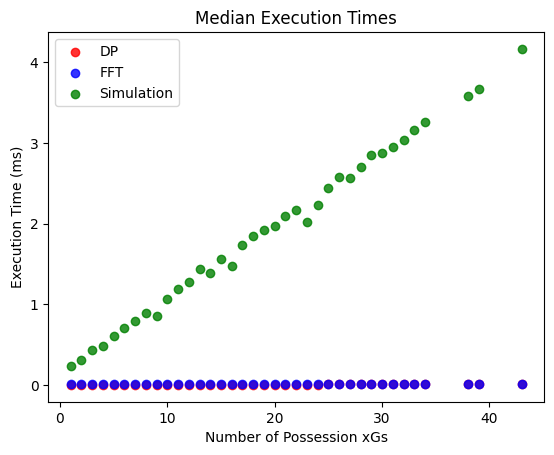

In [23]:
# Plot all the median execution times in milliseconds in one plot
plt.scatter(possession_xg_count, [t/10e6 for t in execution_times_dp], alpha=0.8, c='red', label='DP')
plt.scatter(possession_xg_count, [t/10e6 for t in execution_times_fft], alpha=0.8, c='blue', label='FFT')
plt.scatter(possession_xg_count, [t/10e6 for t in execution_times_sim], alpha=0.8, c='green', label='Simulation')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.show()

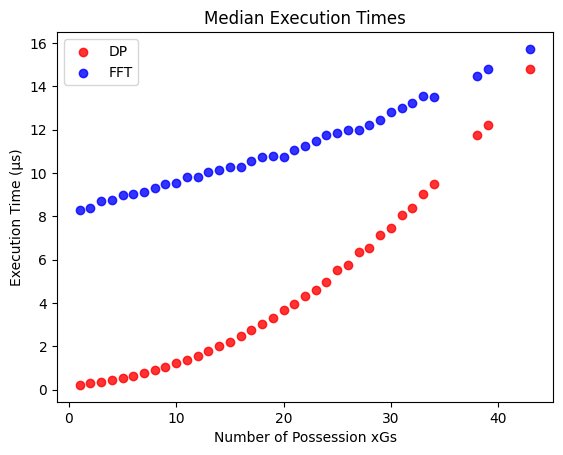

In [24]:
# Plot the median execution times of the deterministic algorithms in microseconds
plt.clf()
plt.scatter(possession_xg_count, [t/10e3 for t in execution_times_dp], alpha=0.8, c='red', label='DP')
plt.scatter(possession_xg_count, [t/10e3 for t in execution_times_fft], alpha=0.8, c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

### Constructed Analysis
The execution times for the DP and FFT algorithm seem to intersect at around 40 $p_i$'s. To analyze this further we can sample from the empirical distribution from the Possession xGs up to 100 $p_i$'s.

In [25]:
execution_times_dp = []
execution_times_fft = []
# N is the maximum number of Possession xGs to call the algorithms on
N = 100
for count in tqdm(range(1, N+1)):
    # Choose p_is from the dataset
    p_is = xg_df.sample(count, replace=True, random_state=SEED)['possession_xg'].to_list()
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    for _ in range(n_reiterate_det):
        # Get DP execution time
        start = time.perf_counter_ns()
        dp(p_is)
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        # Get FFT execution times
        start = time.perf_counter_ns()
        fft(p_is)
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
# Transform the execution times from nanoseconds to microseconds
execution_times_dp = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp]
execution_times_fft = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft]

100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


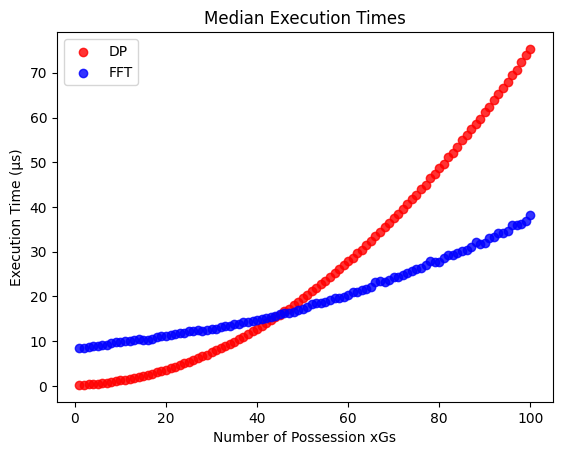

In [26]:
# Plot the excution times for the deterministic algorithms
plt.clf()
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1]) for t in execution_times_dp], alpha=0.8, c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1]) for t in execution_times_fft], alpha=0.8, c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

### Fitting Functions
The DP algorithm has asymptotic runtime $\mathcal{\Theta}(n^2)$, while the FFT algorithm has the asymptotic runtime $\mathcal{\Theta}(n \cdot \log(n))$. Let's now fit the following functions to the execution times:
- DP: $an^2 + bn + c$
- FFT: $dn \cdot \log(n) + en + f$
Where $n$ is the number of $p_i$'s which the algorithms get as input.

In [27]:
# Fit to the DP execution times
dp_x = []
# Transform the counts of the Possession xGs for fitting later 
for n, times in execution_times_dp:
    dp_x.append([n] * len(times))
# Collapse both the number of Possession xGs and execution times into one big list
dp_x = np.array(sum(dp_x, []))
dp_y = np.array(sum([t[1] for t in execution_times_dp], []))
# Get the second degree polynomial features and transform our x values (Number of Possession xGs)
dp_poly = PolynomialFeatures(degree=2, include_bias=False)
dp_poly_features = dp_poly.fit_transform(dp_x.reshape(-1, 1))
# Fit the function to the execution times
dp_poly_reg_model = LinearRegression()
dp_poly_reg_model.fit(dp_poly_features, dp_y)
# Get the predicted execution times
dp_y_predicted = dp_poly_reg_model.predict(dp_poly.fit_transform(np.arange(1, N+1).reshape(-1, 1)))
print(f'DP Regression Model coefficients: {dp_poly_reg_model.coef_}, y_Intercept: {dp_poly_reg_model.intercept_}')
print(f'Root Mean Squared Error to the Medians of execution times: {mean_squared_error([np.median(t[1]) for t in execution_times_dp], dp_y_predicted, squared=False)}')

DP Regression Model coefficients: [0.02922536 0.00722255], y_Intercept: 0.18016892632871162
Root Mean Squared Error to the Medians of execution times: 0.12475343246480211


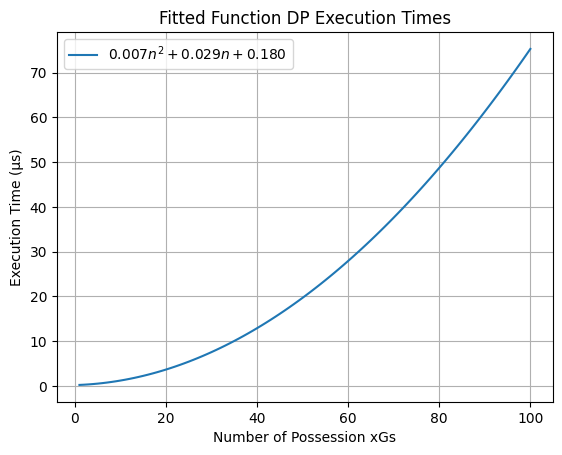

In [28]:
# Plot the fitted DP function
plt.clf()
b, a = dp_poly_reg_model.coef_
plt.plot(range(1, N+1), dp_y_predicted, label=f'${a:.3f}n^2 + {b:.3f}n + {dp_poly_reg_model.intercept_:.3f}$')
plt.title('Fitted Function DP Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.grid()
plt.legend()
plt.show()

In [29]:
# Fit to the FFT execution times
fft_x = []
# Transform the counts of the Possession xGs for fitting later 
for n, times in execution_times_fft:
    fft_x.append([n] * len(times))
# Collapse both the number of Possession xGs and execution times into one big list
fft_x = np.array(sum(fft_x, [])).reshape(-1, 1)
fft_y = np.array(sum([t[1] for t in execution_times_fft], []))
# Transform our x values (Number of Possession xGs)
n_log_n = fft_x * np.log(fft_x)
fft_transformed_x = np.hstack((fft_x, n_log_n))
# Fit the function to the execution times
fft_reg_model = LinearRegression()
fft_reg_model.fit(fft_transformed_x, fft_y)
# Get the predicted execution times
predict_x = np.arange(1, N+1).reshape(-1, 1)
n_log_n = predict_x * np.log(predict_x)
predict_x_transformed = np.hstack((predict_x, n_log_n))
fft_y_predicted = fft_reg_model.predict(predict_x_transformed)
print(f'FFT Regression Model coefficients: {fft_reg_model.coef_}, y_Intercept: {fft_reg_model.intercept_}')
print(f'Root Mean Squared Error to the Medians of execution times: {mean_squared_error([np.median(t[1]) for t in execution_times_fft], fft_y_predicted, squared=False)}')

FFT Regression Model coefficients: [-0.51694288  0.16862423], y_Intercept: 10.781364212251756
Root Mean Squared Error to the Medians of execution times: 0.6009934318177786


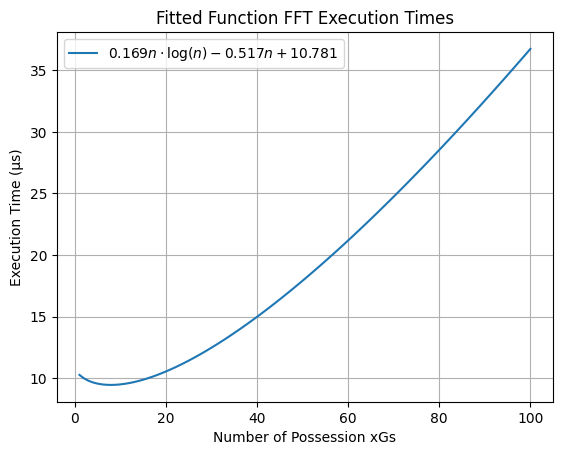

In [30]:
# Plot the fitted FFT function
plt.clf()
d, c = fft_reg_model.coef_
plt.plot(range(1, N+1), fft_y_predicted, label=f'${c:.3f}n \cdot \log(n) {d:.3f}n + {fft_reg_model.intercept_:.3f}$')
plt.title('Fitted Function FFT Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.grid()
plt.legend()
plt.show()

The curves intersect at n = 45.727074599868644


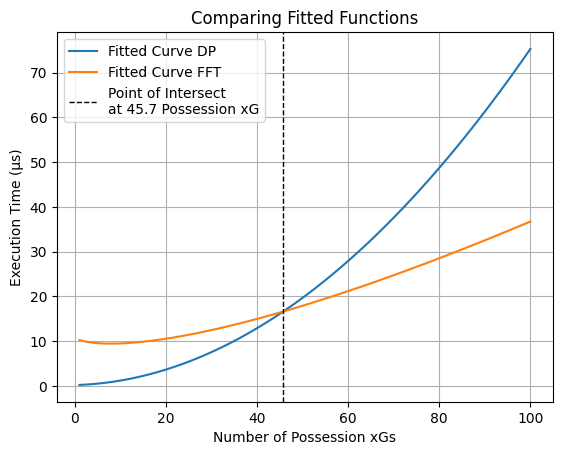

In [31]:
# Compare the two fitted functions
plt.clf()
plt.plot(range(1, N+1), dp_y_predicted, label='Fitted Curve DP')
plt.plot(range(1, N+1), fft_y_predicted, label='Fitted Curve FFT')
# Find the intersection point
dp_func = lambda n: a*n**2 + b*n + dp_poly_reg_model.intercept_
fft_func = lambda n: c * n * np.log(n) + d * n + fft_reg_model.intercept_
diff_func = lambda n: dp_func(n) - fft_func(n)
# Our inital guesses are 35 and 45, as we can estimate that from interpreting the graphs
intersect = fsolve(diff_func, np.array([30, 50]))[0]
print(f'The curves intersect at n = {intersect}')
plt.axvline(intersect, color='black', linestyle='--', linewidth=1, label=f'Point of Intersect\nat {intersect:.1f} Possession xG')
plt.title('Comparing Fitted Functions')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.grid()
plt.legend()
plt.show()

### Presorting of the Input Vector
So far the input vectors have been assumed to be unsorted. We will test the hypothesis, that the deterministic algorithms might perform better when the values in the input vector appear sorted.

In [32]:
execution_times_dp = []
execution_times_fft = []
execution_times_dp_asc = []
execution_times_fft_asc = []
execution_times_dp_desc = []
execution_times_fft_desc = []
# We run the experiment for up to 60 Possession xG values in the input vector
N = 60
for count in tqdm(range(1, N+1)):
    # Sample the input Possession xGs from the dataset
    p_is = xg_df.sample(count, replace=True, random_state=SEED)['possession_xg'].to_list()
    # Sort the values in ascening, respectively descending order
    p_is_asc = sorted(p_is, reverse=False)
    p_is_desc = sorted(p_is, reverse=True)
    # Get the execution times for the deterministic algorithms for both ascending and descending sorted input vector
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_dp_asc_agg = []
    execution_times_fft_asc_agg = []
    execution_times_dp_desc_agg = []
    execution_times_fft_desc_agg = []
    for _ in range(n_reiterate_det):
        # Get the execution time for the DP algorithm unsorted
        start = time.perf_counter_ns()
        dp(p_is)
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        # Get the execution time for the DP algorithm ascending sorted
        start = time.perf_counter_ns()
        dp(p_is_asc)
        stop = time.perf_counter_ns()
        execution_times_dp_asc_agg.append(stop - start)
        # Get the execution time for the DP algorithm descending sorted
        start = time.perf_counter_ns()
        dp(p_is_desc)
        stop = time.perf_counter_ns()
        execution_times_dp_desc_agg.append(stop - start)
        # Get the execution time for the FFT algorithm unsorted
        start = time.perf_counter_ns()
        fft(p_is)
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
        # Get the execution time for the FFT algorithm ascending sorted
        start = time.perf_counter_ns()
        fft(p_is_asc)
        stop = time.perf_counter_ns()
        execution_times_fft_asc_agg.append(stop - start)
        # Get the execution time for the FFT algorithm descending sorted
        start = time.perf_counter_ns()
        fft(p_is_desc)
        stop = time.perf_counter_ns()
        execution_times_fft_desc_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
    execution_times_dp_asc.append((count, execution_times_dp_asc_agg))
    execution_times_fft_asc.append((count, execution_times_fft_asc_agg))
    execution_times_dp_desc.append((count, execution_times_dp_desc_agg))
    execution_times_fft_desc.append((count, execution_times_fft_desc_agg))
# Transform the execution times from nanoseconds to microseconds
execution_times_dp = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp]
execution_times_fft = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft]
execution_times_dp_asc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp_asc]
execution_times_fft_asc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft_asc]
execution_times_dp_desc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_dp_desc]
execution_times_fft_desc = [(t[0], [time/10e3 for time in t[1]]) for t in execution_times_fft_desc]

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [03:40<00:00,  3.67s/it]


In [33]:
# Let us have a look at the maximum absolute difference of the median execution times of the ordered values to the normal input values
max_abs_diff_dp_asc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_dp]) - np.array([np.median(t[1]) for t in execution_times_dp_asc])))
max_abs_diff_dp_desc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_dp]) - np.array([np.median(t[1]) for t in execution_times_dp_desc])))
max_abs_diff_fft_asc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_fft]) - np.array([np.median(t[1]) for t in execution_times_fft_asc])))
max_abs_diff_fft_desc = np.max(np.absolute(np.array([np.median(t[1]) for t in execution_times_fft]) - np.array([np.median(t[1]) for t in execution_times_fft_desc])))
print(f'Maximum absolute difference between medians of normal input vs. ascending sorted input DP: {max_abs_diff_dp_asc}')
print(f'Maximum absolute difference between medians of normal input vs. descending sorted input DP: {max_abs_diff_dp_desc}')
print(f'Maximum absolute difference between medians of normal input vs. ascending sorted input FFT: {max_abs_diff_fft_asc}')
print(f'Maximum absolute difference between medians of normal input vs. descending sorted input FFT: {max_abs_diff_fft_desc}')

Maximum absolute difference between medians of normal input vs. ascending sorted input DP: 0.23559999999999803
Maximum absolute difference between medians of normal input vs. descending sorted input DP: 0.2848000000000006
Maximum absolute difference between medians of normal input vs. ascending sorted input FFT: 1.203800000000001
Maximum absolute difference between medians of normal input vs. descending sorted input FFT: 1.2454500000000017


It seems like sorting the input has no considerable effect on execution time for the DP algorithm. For the FFT algorithm there seems to be a more considerable effect. Let us plot these execution times.

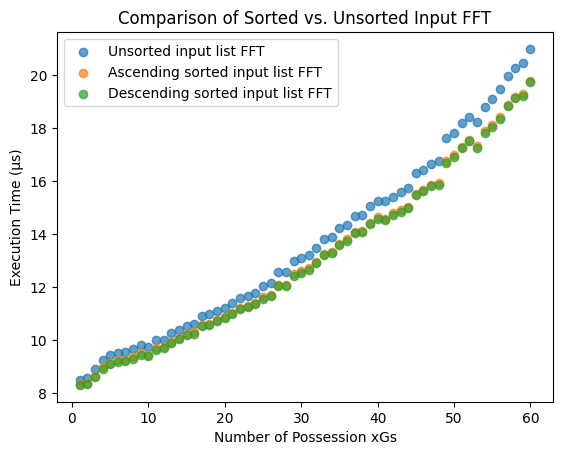

In [34]:
# Plot execution times for all input sorting strategies for the FFT algorithm
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft], alpha=0.7, label='Unsorted input list FFT')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_asc], alpha=0.7, label='Ascending sorted input list FFT')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_desc], alpha=0.7, label='Descending sorted input list FFT')
plt.title('Comparison of Sorted vs. Unsorted Input FFT')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

For the notion of completeness let's also compare the unsorted vs. sorted input graphically for the DP algorithm.

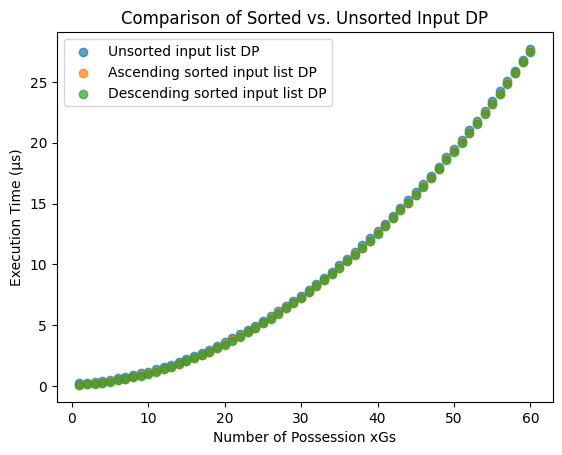

In [35]:
# Plot execution times for all input sorting strategies for the DP algorithm
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp], alpha=0.7, label='Unsorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp_asc], alpha=0.7, label='Ascending sorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp_desc], alpha=0.7, label='Descending sorted input list DP')
plt.title('Comparison of Sorted vs. Unsorted Input DP')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

Both deterministic algorithms seem to profit off of sorting the input list. While the FFT algorithm seems to have a better speedup, the speedup provided by sorting is neglible for the DP algorithm. Of the two sorted directions there seems to be a slight bias of speedup in the descending sorted order for both algorithms. To assess if this finding changes the result of the comparison of the deterministic algorithm we plot the best sorting strategy for the FFT algorithm together with the default (unsorted) strategy of the DP algorithm.

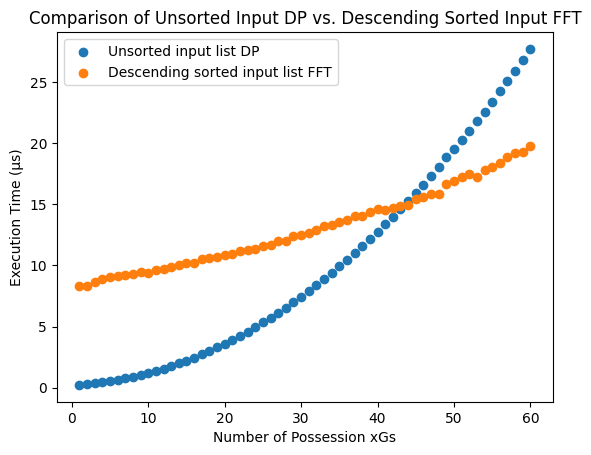

In [36]:
# Compare the descending ordered input list FFT algorithm to the unsorted DP algorithm
plt.clf()
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_dp], label='Unsorted input list DP')
plt.scatter(range(1, N+1), [np.median(t[1]) for t in execution_times_fft_desc], label='Descending sorted input list FFT')
plt.title('Comparison of Unsorted Input DP vs. Descending Sorted Input FFT')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()